<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы-по-проекту" data-toc-modified-id="Выводы-по-проекту-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы по проекту</a>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем нужные библиотеки для дальнейшей работы:

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
try:
    data = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\toxic_comments.csv', index_col=[0])
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

Проверим данные на наличие дубликатов, пропущенных значений, выведем общую информацию датафрейма и посмотрим первые 5 строк с помощью метода `head()`

In [3]:
def show (data):
    print('Количество дубликатов:', data.duplicated().sum())
    print()
    print('Количество пропущенных значений:\n', data.isna().sum())
    print()
    print('Размер таблицы:', data.shape)
    print()
    data.info()
    return data.head()
show(data)

Количество дубликатов: 0

Количество пропущенных значений:
 text     0
toxic    0
dtype: int64

Размер таблицы: (159292, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


В комментариях обнаружены спец.символы. Очистим их с помощью регулярных выражений и лемматизируем

In [4]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]+", " ", text)
    return text.strip().lower()

In [5]:
wnl = WordNetLemmatizer()
tknzr = TweetTokenizer()
def lemmatize(text, m=wnl):
    word_list = tknzr.tokenize(text)
    lemma_list = []
    for word, tag in nltk.pos_tag(word_list):
        if tag.startswith('NN'):
            lemma = m.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            lemma = m.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            lemma = m.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            lemma = m.lemmatize(word, pos='r')
        else:
            lemma = m.lemmatize(word)
        lemma_list.append(lemma)
    return ' '.join(lemma_list)

data['text'] = data['text'].apply(clean_text)
data['text'] = data['text'].apply(lemmatize)
data.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Посмотрим на распределение целевого признака `toxic`:

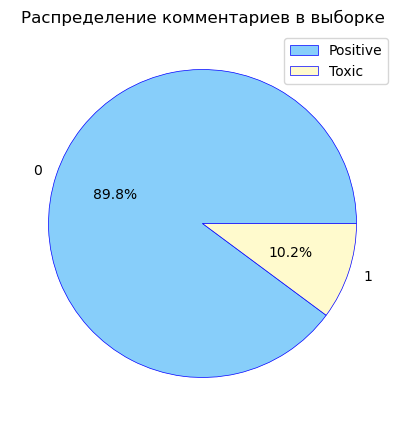

In [6]:
data['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6.5,5), colors=['#87CEFA', '#FFFACD'],
                                 wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
plt.legend(['Positive','Toxic'])
plt.title('Распределение комментариев в выборке')
plt.axis('off');

В выборке присутствует дисбаланс. Позитивных комментариев больше (90%), чем негативных (10%).

**Вывод:**
- мы импортировали нужные библиотеки для дальнейшей работы и загрузили данные
- проверили данные на наличие дубликатов, пропущенных значений, вывели общую информацию датафрейма, дубликаты и пропущенные значения найдены не были
- в комментариях были обнаружены спец.символы, очистили их с помощью регулярных выражений и лемматизировали
- посмотрели на распределение целевого признака `toxic` и выяснили, что в выборке присутствует дисбаланс: позитивных комментариев больше (90%), чем негативных (10%)

## Обучение

Разделим выборку на тренировочную и тестовую в соотношении 90/10 , сохраним пропорции целевой переменной в обучающей и тестовой выборках при разделении данных с помощью параметра `stratify`:

In [7]:
features = data['text']
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1,
                                                                            random_state=123, stratify=data.toxic)
print(f'Размер обучающей выборки: {len (features_train) / len(data):.0%}')
print(f'Размер тестовой выборки: {len (features_test) / len(data):.0%}')

Размер обучающей выборки: 90%
Размер тестовой выборки: 10%


Установим набор стоп-слов stop_words для удаления из текста, также установим ngram_range для создания n-грамм текста. Преобразуем текстовые данные матрицу, используя весовую схему TF-IDF:

In [9]:
stop_words = set(stopwords.words('english'))
tfv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))

Приступим к обучению моделей:

In [10]:
tfv_lr_pipeline = Pipeline([('tfv', tfv),
                            ('lr', LogisticRegression(random_state=123))])
params_tfv_lr = {'lr__class_weight': ['balanced'],
                 'lr__C': [10],
                 'lr__max_iter': [500]}

grid_tfv_lr = GridSearchCV(tfv_lr_pipeline, param_grid=params_tfv_lr, scoring='f1', verbose=3, cv=5, n_jobs=-1)
grid_tfv_lr.fit(features_train, target_train)
print('Лучшие параметры Logistic Regression на кросс-валидационной выборке:', grid_tfv_lr.best_params_)
print('F1:', round(grid_tfv_lr.best_score_, 5))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры Logistic Regression на кросс-валидационной выборке: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__max_iter': 500}
F1: 0.75564


In [11]:
tfv_sgd_pipeline = Pipeline([('tfv', tfv),
                             ('sgd', SGDClassifier(random_state=123))])

params_tfv_sgd = {'sgd__class_weight': ['balanced', None],
                  'sgd__max_iter': [500, 1000],
                  'sgd__loss': ['log', 'squared_hinge'],
                  'sgd__penalty': ['l1'],
                  'sgd__shuffle': [True],
                  'sgd__n_iter_no_change': [10, 20]}

grid_tfv_sgd = GridSearchCV(tfv_sgd_pipeline, param_grid=params_tfv_sgd, scoring='f1', verbose=3, cv=5, n_jobs=-1)
grid_tfv_sgd.fit(features_train, target_train)
print('Лучшие параметры SGDClassifier на кросс-валидационной выборке:', grid_tfv_sgd.best_params_)
print('F1:', round(grid_tfv_sgd.best_score_, 5))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры SGDClassifier на кросс-валидационной выборке: {'sgd__class_weight': 'balanced', 'sgd__loss': 'log', 'sgd__max_iter': 500, 'sgd__n_iter_no_change': 20, 'sgd__penalty': 'l1', 'sgd__shuffle': True}
F1: 0.71491


Лучший результат метрики f1 на кросс-валидационной выборке показала модель логистической регрессии, проверим ее качество на тестовой выборке:

In [12]:
prediction = grid_tfv_lr.predict(features_test)
print('F1 для Logisctic Regression на тестовой выборке:', round(f1_score(target_test, prediction), 5))

F1 для Logisctic Regression на тестовой выборке: 0.76628


Проанализируем результаты классификации модели с помощью матрицы ошибок:

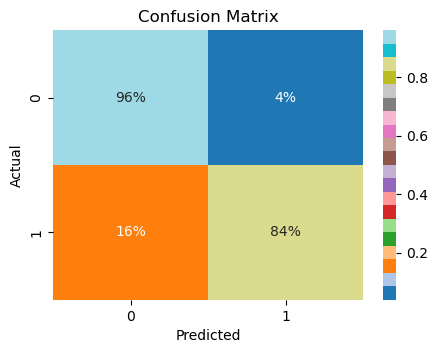

In [13]:
plt.figure(figsize=(5,3.5))
ax = plt.subplot()
sns.heatmap(confusion_matrix(target_test, prediction, normalize='true'), annot=True, fmt='.0%', cmap="tab20")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix');

False Positive и False Negative различается, но расхождения не критичные, процент правильно предсказанных значений достаточно высокий

**Вывод:**
- разделили выборку на тренировочную и тестовую в соотношении 80/20 , сохранили пропорции целевой переменной в обучающей и тестовой выборках при разделении данных с помощью параметра `stratify`
- преобразовали тип данных столбца text в тип Unicode (U)
- установили набор стоп-слов stop_words для удаления из текста, также установили ngram_range для создания n-грамм текста
- преобразовали текстовые данные в векторы, используя весовую схему TF-IDF. ngram_range=(1,2) позволил использовать векторизацию с учетом как отдельных слов, так и двух слов (биграмм) в тексте, что помогло учесть контекст и смысловые связи между словами
- обучили модели классификации Logistic Regression и SGDClassifier, лучший результат метрики f1 на кросс-валидационной выборке показала модель логистической регрессии, проверили ее качество на тестовой выборке, результат F1 для Logisctic Regression на тестовой выборке равен 0.76628
- проанализировали результаты классификации модели с помощью матрицы ошибок и выяснили, False Positive и False Negative различается, но расхождения не критичные, процент правильно предсказанных значений достаточно высокий

## Выводы по проекту

- мы загрузили, проанализировали и подготовили данныее
- разделили выборку на тренировочную и тестовую, установили набор стоп-слов stop_words для удаления из текста, также установили ngram_range для создания n-грамм текста, преобразовали текстовые данные в векторы, используя весовую схему TF-IDF
- обучили модели классификации Logistic Regression и SGDClassifier, лучший результат метрики f1 на кросс-валидационной выборке показала модель логистической регрессии, проверили ее качество на тестовой выборке, результат F1 для Logisctic Regression на тестовой выборке равен 0.76628
- проанализировали результаты классификации модели с помощью матрицы ошибок.
- результат f1 для Logisctic Regression на тестовой выборке: 0.76628, что удовлетворяет условию задачи